In [1]:
import pandas as pd
import numpy as np
import json
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LENGTH = 100
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
BATCH_SIZE = 32
LEARNING_RATE = 0.0008
NUM_EPOCHS = 15
DROPOUT_RATE = 0.6
FOCAL_LOSS_GAMMA = 2.0  # Parameter for focal loss

## Load Data

In [3]:
# File paths (Kaggle)
TRAIN_PATH = '/kaggle/input/deception/train (1).jsonl'
VALIDATION_PATH = '/kaggle/input/deception/validation.jsonl'
TEST_PATH = '/kaggle/input/deception/test.jsonl'

# File paths (local)
#TRAIN_PATH = 'data/train.jsonl'
#VALIDATION_PATH = 'data/validation.jsonl'
#TEST_PATH = 'data/test.jsonl'

In [4]:
# Load and preprocess data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            game_data = json.loads(line.strip())

            for i in range(len(game_data['messages'])):
                if game_data['sender_labels'][i] == "NOANNOTATION":
                    continue

                entry = {
                    'message': game_data['messages'][i],
                    'speaker': game_data['speakers'][i],
                    'receiver': game_data['receivers'][i],
                    'score_delta': float(game_data['game_score_delta'][i]) if 'game_score_delta' in game_data else 0,
                    'abs_msg_idx': game_data['absolute_message_index'][i],
                    'rel_msg_idx': game_data['relative_message_index'][i],
                    'year': int(game_data['years'][i]) if 'years' in game_data else 1900,
                    'season': game_data['seasons'][i] if 'seasons' in game_data else "Unknown",
                    'message_length': len(game_data['messages'][i]),
                    'is_deceptive': 1 if game_data['sender_labels'][i] == False else 0  # deceptive=1, truthful=0
                }
                data.append(entry)

    return pd.DataFrame(data)

In [5]:
# Load datasets
print("Loading datasets...")
train_df = load_data(TRAIN_PATH)
val_df = load_data(VALIDATION_PATH)
test_df = load_data(TEST_PATH)

Loading datasets...


In [6]:
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 13132, Validation size: 1416, Test size: 2741


In [7]:
# Show class distribution
print("Class distribution in training data:")
class_dist = train_df['is_deceptive'].value_counts(normalize=True)
print(class_dist)

Class distribution in training data:
is_deceptive
0    0.954995
1    0.045005
Name: proportion, dtype: float64


## Preprocess Data

In [8]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
# Apply preprocessing
train_df['processed_message'] = train_df['message'].apply(preprocess_text)
val_df['processed_message'] = val_df['message'].apply(preprocess_text)
test_df['processed_message'] = test_df['message'].apply(preprocess_text)

In [10]:
# Extract season as one-hot encoded feature
def encode_season(season):
    seasons = ['Spring', 'Summer', 'Fall', 'Winter']
    encoding = [0] * len(seasons)
    try:
        idx = seasons.index(season)
        encoding[idx] = 1
    except ValueError:
        pass
    return encoding

In [11]:
# Apply season encoding
train_df['season_encoded'] = train_df['season'].apply(encode_season)
val_df['season_encoded'] = val_df['season'].apply(encode_season)
test_df['season_encoded'] = test_df['season'].apply(encode_season)

In [12]:
# Normalize year
def normalize_year(year):
    return (year - 1900) / 10

In [13]:
# Normalize year
train_df['year_normalized'] = train_df['year'].apply(normalize_year)
val_df['year_normalized'] = val_df['year'].apply(normalize_year)
test_df['year_normalized'] = test_df['year'].apply(normalize_year)

In [14]:
# Normalize message length
def normalize_length(length):
    return min(length / 100, 5)

In [15]:
# Normalize message length
train_df['length_normalized'] = train_df['message_length'].apply(normalize_length)
val_df['length_normalized'] = val_df['message_length'].apply(normalize_length)
test_df['length_normalized'] = test_df['message_length'].apply(normalize_length)

In [16]:
# Save processed data
train_df.to_csv('train_processed.csv', index=False)
val_df.to_csv('val_processed.csv', index=False)
test_df.to_csv('test_processed.csv', index=False)

## Dataset

In [17]:
# Build vocabulary
def build_vocab(texts, max_size):
    word_counts = Counter()
    for text in texts:
        words = text.split()
        word_counts.update(words)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in word_counts.most_common(max_size - len(vocab)):
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

In [18]:
print("Building vocabulary...")
vocab = build_vocab(train_df['processed_message'], MAX_VOCAB_SIZE)
print(f"Vocabulary size: {len(vocab)}")

Building vocabulary...
Vocabulary size: 8633


In [19]:
def tokenize(text, vocab, max_length):
    words = text.split()
    tokens = [vocab.get(word, vocab['<UNK>']) for word in words[:max_length]]

    if len(tokens) < max_length:
        tokens = tokens + [vocab['<PAD>']] * (max_length - len(tokens))

    return tokens

In [20]:
# Dataset class
class DiplomacyDataset(Dataset):
    def __init__(self, dataframe, vocab, max_length):
        self.messages = [tokenize(text, vocab, max_length) for text in dataframe['processed_message']]
        self.score_deltas = dataframe['score_delta'].values
        self.rel_msg_indices = dataframe['rel_msg_idx'].values / 10.0  # Normalize
        self.abs_msg_indices = dataframe['abs_msg_idx'].values / 1000.0  # Normalize
        self.years = dataframe['year_normalized'].values
        self.seasons = np.stack(dataframe['season_encoded'].values)
        self.message_lengths = dataframe['length_normalized'].values
        self.labels = dataframe['is_deceptive'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'message': torch.tensor(self.messages[idx], dtype=torch.long),
            'score_delta': torch.tensor(self.score_deltas[idx], dtype=torch.float),
            'rel_msg_idx': torch.tensor(self.rel_msg_indices[idx], dtype=torch.float),
            'abs_msg_idx': torch.tensor(self.abs_msg_indices[idx], dtype=torch.float),
            'year': torch.tensor(self.years[idx], dtype=torch.float),
            'season': torch.tensor(self.seasons[idx], dtype=torch.float),
            'msg_length': torch.tensor(self.message_lengths[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [21]:
# Create datasets
print("Creating datasets...")
train_dataset = DiplomacyDataset(train_df, vocab, MAX_SEQ_LENGTH)
val_dataset = DiplomacyDataset(val_df, vocab, MAX_SEQ_LENGTH)
test_dataset = DiplomacyDataset(test_df, vocab, MAX_SEQ_LENGTH)

Creating datasets...


In [22]:
# Calculate class weights for weighted sampling
class_counts = np.bincount(train_df['is_deceptive'])
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in train_df['is_deceptive']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_df), replacement=True)

In [23]:
# Create data loaders with weighted sampler for training
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [24]:
# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha 
        self.size_average = size_average
        if alpha is not None:
            self.criterion = nn.CrossEntropyLoss(weight=alpha, reduction='none')
        else:
            self.criterion = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.criterion(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.size_average:
            return focal_loss.mean()
        else:
            return focal_loss.sum()

In [25]:
# LSTM Model with attention
class DeceptionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_rate, num_layers=2):
        super(DeceptionLSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           batch_first=True, bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)

        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        self.feature_layer = nn.Linear(9, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * 2 + hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)

    def attention_net(self, lstm_output):
        attn_weights = torch.tanh(self.attention(lstm_output))
        soft_attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights)
        return context.squeeze(2)

    def forward(self, message, score_delta, rel_msg_idx, abs_msg_idx, year, season, msg_length):
        embedded = self.embedding(message)
        lstm_out, _ = self.lstm(embedded)
        attn_out = self.attention_net(lstm_out)
        attn_out = self.dropout(attn_out)

        features = torch.cat([
            score_delta.unsqueeze(1),
            rel_msg_idx.unsqueeze(1),
            abs_msg_idx.unsqueeze(1),
            year.unsqueeze(1),
            season,  
            msg_length.unsqueeze(1)
        ], dim=1)

        feature_out = torch.relu(self.feature_layer(features))
        combined = torch.cat([attn_out, feature_out], dim=1)
        hidden = torch.relu(self.fc1(combined))
        hidden = self.dropout(hidden)
        output = self.fc2(hidden)

        return output

In [26]:
# Initialize model
model = DeceptionLSTM(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout_rate=DROPOUT_RATE,
    num_layers=2
)

In [27]:
# Calculate class weights for loss function
class_counts = np.bincount(train_df['is_deceptive'])
class_weights = torch.FloatTensor([1.0 / class_counts[0], 1.0 / class_counts[1]])
class_weights = class_weights / class_weights.sum()  
class_weights = class_weights * 2  

In [28]:
# Define loss function
criterion = FocalLoss(gamma=FOCAL_LOSS_GAMMA, alpha=class_weights)

In [29]:
# Added L2 regularization
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [30]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Train and Evaluate

In [31]:
# Training function
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(data_loader, desc="Training"):
        messages = batch['message'].to(device)
        score_deltas = batch['score_delta'].to(device)
        rel_msg_indices = batch['rel_msg_idx'].to(device)
        abs_msg_indices = batch['abs_msg_idx'].to(device)
        years = batch['year'].to(device)
        seasons = batch['season'].to(device)
        msg_lengths = batch['msg_length'].to(device)
        labels = batch['label'].to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(messages, score_deltas, rel_msg_indices, abs_msg_indices, years, seasons, msg_lengths)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    return total_loss / len(data_loader), accuracy, f1

In [32]:
# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []  

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Get data
            messages = batch['message'].to(device)
            score_deltas = batch['score_delta'].to(device)
            rel_msg_indices = batch['rel_msg_idx'].to(device)
            abs_msg_indices = batch['abs_msg_idx'].to(device)
            years = batch['year'].to(device)
            seasons = batch['season'].to(device)
            msg_lengths = batch['msg_length'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(messages, score_deltas, rel_msg_indices, abs_msg_indices, years, seasons, msg_lengths)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())  

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    f1 = f1_score(all_labels, all_preds, average='macro')

    return total_loss / len(data_loader), accuracy, f1, all_preds, all_probs, all_labels

In [33]:
# Find optimal threshold
def find_optimal_threshold(y_true, y_probs):
    best_f1 = 0
    best_threshold = 0.5

    for threshold in np.arange(0.1, 0.9, 0.05):
        y_pred = (np.array(y_probs) >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, average='macro')

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

In [34]:
# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')

In [35]:
# Training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, device):
    best_val_f1 = 0.0
    history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
               'val_loss': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        val_loss, val_acc, val_f1, _, val_probs, val_labels = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_f1)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        #Finding optimal threshold
        threshold, _ = find_optimal_threshold(val_labels, val_probs)
        print(f"Optimal threshold: {threshold:.2f}")

        #best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'threshold': threshold,
                'epoch': epoch
            }, '/kaggle/working//best_model.pt')
            print("Saved best model!")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')

    return model, threshold

## Execution

In [36]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [37]:
# Move model and criterion to device
model = model.to(device)
criterion = criterion.to(device)

Starting training...
Epoch 1/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 322.84it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0159, Train Acc: 0.5055, Train F1: 0.3370
Val Loss: 0.0089, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.10
Saved best model!
Epoch 2/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 325.99it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0090, Train Acc: 0.4994, Train F1: 0.3331
Val Loss: 0.0084, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 3/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 314.98it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0079, Train Acc: 0.5066, Train F1: 0.3363
Val Loss: 0.0082, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 4/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 317.64it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0070, Train Acc: 0.4989, Train F1: 0.3330
Val Loss: 0.0092, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 5/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 315.70it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.06      0.12      1360
           1       0.04      0.95      0.08        56

    accuracy                           0.10      1416
   macro avg       0.50      0.51      0.10      1416
weighted avg       0.93      0.10      0.12      1416


Confusion Matrix:
[[  88 1272]
 [   3   53]]
Train Loss: 0.0057, Train Acc: 0.5204, Train F1: 0.3811
Val Loss: 0.0099, Val Acc: 0.0996, Val F1: 0.0990
Optimal threshold: 0.85
Saved best model!
Epoch 6/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 318.91it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.40      0.57      1360
           1       0.05      0.71      0.09        56

    accuracy                           0.42      1416
   macro avg       0.51      0.56      0.33      1416
weighted avg       0.94      0.42      0.55      1416


Confusion Matrix:
[[548 812]
 [ 16  40]]
Train Loss: 0.0051, Train Acc: 0.5783, Train F1: 0.4845
Val Loss: 0.0263, Val Acc: 0.4153, Val F1: 0.3289
Optimal threshold: 0.85
Saved best model!
Epoch 7/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 270.50it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.38      0.55      1360
           1       0.05      0.84      0.10        56

    accuracy                           0.40      1416
   macro avg       0.52      0.61      0.33      1416
weighted avg       0.95      0.40      0.53      1416


Confusion Matrix:
[[522 838]
 [  9  47]]
Train Loss: 0.0047, Train Acc: 0.6318, Train F1: 0.5740
Val Loss: 0.0227, Val Acc: 0.4018, Val F1: 0.3260
Optimal threshold: 0.85
Epoch 8/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 315.21it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.40      0.57      1360
           1       0.05      0.77      0.09        56

    accuracy                           0.41      1416
   macro avg       0.51      0.58      0.33      1416
weighted avg       0.94      0.41      0.55      1416


Confusion Matrix:
[[542 818]
 [ 13  43]]
Train Loss: 0.0043, Train Acc: 0.6648, Train F1: 0.6180
Val Loss: 0.0271, Val Acc: 0.4131, Val F1: 0.3299
Optimal threshold: 0.85
Saved best model!
Epoch 9/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 311.18it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.19      0.32      1360
           1       0.05      0.95      0.09        56

    accuracy                           0.22      1416
   macro avg       0.52      0.57      0.20      1416
weighted avg       0.95      0.22      0.31      1416


Confusion Matrix:
[[ 260 1100]
 [   3   53]]
Train Loss: 0.0045, Train Acc: 0.6759, Train F1: 0.6383
Val Loss: 0.0100, Val Acc: 0.2210, Val F1: 0.2040
Optimal threshold: 0.85
Epoch 10/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 312.87it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.45      0.62      1360
           1       0.05      0.70      0.09        56

    accuracy                           0.46      1416
   macro avg       0.51      0.57      0.36      1416
weighted avg       0.94      0.46      0.60      1416


Confusion Matrix:
[[615 745]
 [ 17  39]]
Train Loss: 0.0039, Train Acc: 0.6824, Train F1: 0.6439
Val Loss: 0.0324, Val Acc: 0.4619, Val F1: 0.3552
Optimal threshold: 0.85
Saved best model!
Epoch 11/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 323.48it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.54      0.69      1360
           1       0.05      0.61      0.09        56

    accuracy                           0.54      1416
   macro avg       0.51      0.57      0.39      1416
weighted avg       0.93      0.54      0.67      1416


Confusion Matrix:
[[734 626]
 [ 22  34]]
Train Loss: 0.0036, Train Acc: 0.7243, Train F1: 0.7003
Val Loss: 0.0455, Val Acc: 0.5424, Val F1: 0.3944
Optimal threshold: 0.85
Saved best model!
Epoch 12/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 316.02it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.50      0.66      1360
           1       0.05      0.68      0.10        56

    accuracy                           0.51      1416
   macro avg       0.51      0.59      0.38      1416
weighted avg       0.94      0.51      0.64      1416


Confusion Matrix:
[[679 681]
 [ 18  38]]
Train Loss: 0.0038, Train Acc: 0.7016, Train F1: 0.6750
Val Loss: 0.0360, Val Acc: 0.5064, Val F1: 0.3791
Optimal threshold: 0.85
Epoch 13/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 300.02it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.55      0.70      1360
           1       0.06      0.70      0.11        56

    accuracy                           0.55      1416
   macro avg       0.52      0.62      0.40      1416
weighted avg       0.94      0.55      0.68      1416


Confusion Matrix:
[[742 618]
 [ 17  39]]
Train Loss: 0.0035, Train Acc: 0.7189, Train F1: 0.6940
Val Loss: 0.0397, Val Acc: 0.5516, Val F1: 0.4049
Optimal threshold: 0.85
Saved best model!
Epoch 14/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 320.76it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.56      0.71      1360
           1       0.06      0.68      0.11        56

    accuracy                           0.56      1416
   macro avg       0.52      0.62      0.41      1416
weighted avg       0.94      0.56      0.68      1416


Confusion Matrix:
[[756 604]
 [ 18  38]]
Train Loss: 0.0033, Train Acc: 0.6933, Train F1: 0.6615
Val Loss: 0.0412, Val Acc: 0.5607, Val F1: 0.4087
Optimal threshold: 0.85
Saved best model!
Epoch 15/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 320.83it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.42      0.59      1360
           1       0.06      0.84      0.11        56

    accuracy                           0.44      1416
   macro avg       0.52      0.63      0.35      1416
weighted avg       0.95      0.44      0.57      1416


Confusion Matrix:
[[571 789]
 [  9  47]]
Train Loss: 0.0031, Train Acc: 0.7438, Train F1: 0.7234
Val Loss: 0.0234, Val Acc: 0.4364, Val F1: 0.3470
Optimal threshold: 0.85


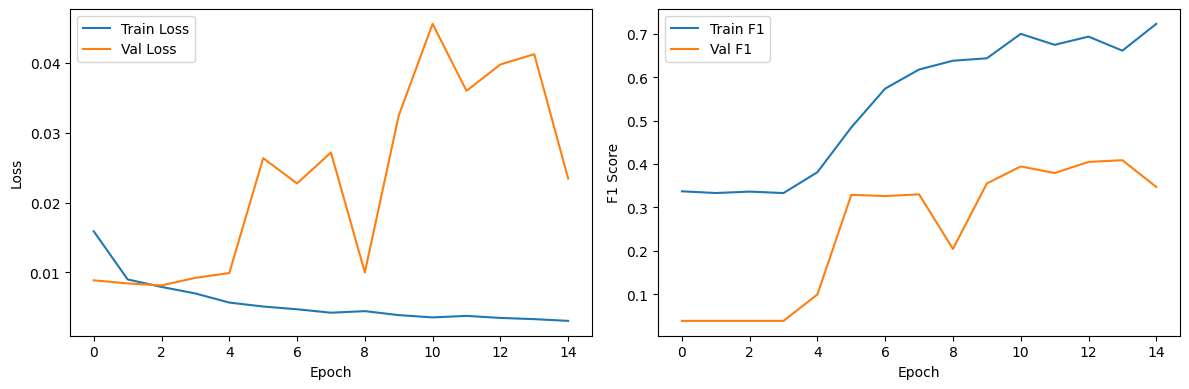

In [38]:
# Train model
print("Starting training...")
model, threshold = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=device
)

## Load and evaluate model

In [39]:
# Load best model
checkpoint = torch.load('/kaggle/working//best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
threshold = checkpoint['threshold']
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with threshold {threshold:.2f}")

Loaded best model from epoch 14 with threshold 0.85


<ipython-input-39-2b0d69fc4bcf>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working//best_model.pt')


In [40]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc, test_f1, test_preds, test_probs, test_labels = evaluate(model, test_loader, criterion, device)

Evaluating on test set...


Evaluating: 100%|██████████| 86/86 [00:00<00:00, 322.53it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.53      0.68      2501
           1       0.10      0.54      0.17       240

    accuracy                           0.53      2741
   macro avg       0.51      0.54      0.42      2741
weighted avg       0.85      0.53      0.63      2741


Confusion Matrix:
[[1333 1168]
 [ 110  130]]


In [41]:
# Apply optimal threshold
test_preds_threshold = (np.array(test_probs) >= threshold).astype(int)
threshold_acc = accuracy_score(test_labels, test_preds_threshold)
threshold_f1 = f1_score(test_labels, test_preds_threshold, average='macro')

In [42]:
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")
print(f"With optimal threshold: Test Acc: {threshold_acc:.4f}, Test F1: {threshold_f1:.4f}")

Test Loss: 0.1102, Test Acc: 0.5337, Test F1: 0.4225
With optimal threshold: Test Acc: 0.6702, Test F1: 0.4781


In [43]:
# Print classification report with optimal threshold
print("\nClassification Report (with optimal threshold):")
print(classification_report(test_labels, test_preds_threshold))


Classification Report (with optimal threshold):
              precision    recall  f1-score   support

           0       0.92      0.70      0.79      2501
           1       0.10      0.36      0.16       240

    accuracy                           0.67      2741
   macro avg       0.51      0.53      0.48      2741
weighted avg       0.85      0.67      0.74      2741



In [44]:
# Print confusion matrix with optimal threshold
print("\nConfusion Matrix (with optimal threshold):")
cm = confusion_matrix(test_labels, test_preds_threshold)
print(cm)


Confusion Matrix (with optimal threshold):
[[1750  751]
 [ 153   87]]


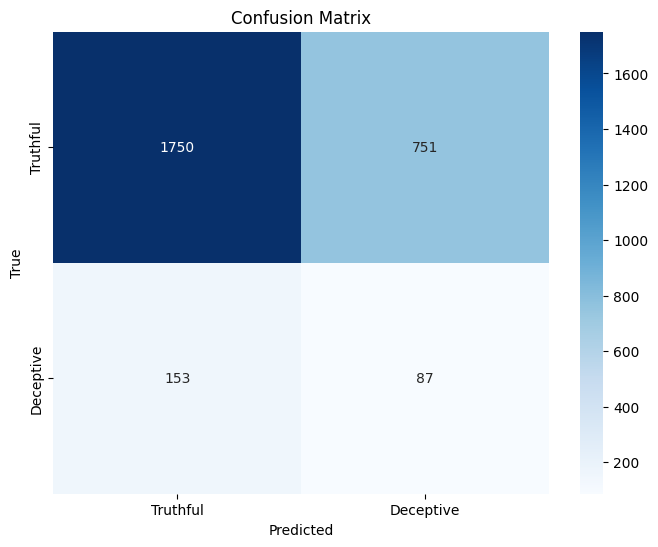

In [45]:
# Plot confusion matrix
plot_confusion_matrix(cm, ['Truthful', 'Deceptive'])

In [46]:
# Save predictions
test_predictions = pd.DataFrame({
    'predicted_prob': test_probs,
    'predicted_label': test_preds_threshold,
    'true_label': test_labels
})
test_predictions.to_csv('test_predictions.csv', index=False)

print("Test predictions saved.")


Test predictions saved.


Using device: cuda
Loading datasets...
Train dataset size: 13132
Validation dataset size: 1416
Test dataset size: 2741
Train dataset - Lies: 591, Truths: 12541, Ratio: 0.05


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/1


Evaluating: 100%|██████████| 89/89 [00:38<00:00,  2.31it/s, loss=2.25, avg_loss=0.809] 


Train Loss: 0.8621, Train Acc: 0.9270
Val Loss: 0.8095, Val Acc: 0.9061
Validation Confusion Matrix:
[[1280   80]
 [  53    3]]

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1360
         1.0       0.04      0.05      0.04        56

    accuracy                           0.91      1416
   macro avg       0.50      0.50      0.50      1416
weighted avg       0.92      0.91      0.91      1416

New best model saved with validation accuracy: 0.9061


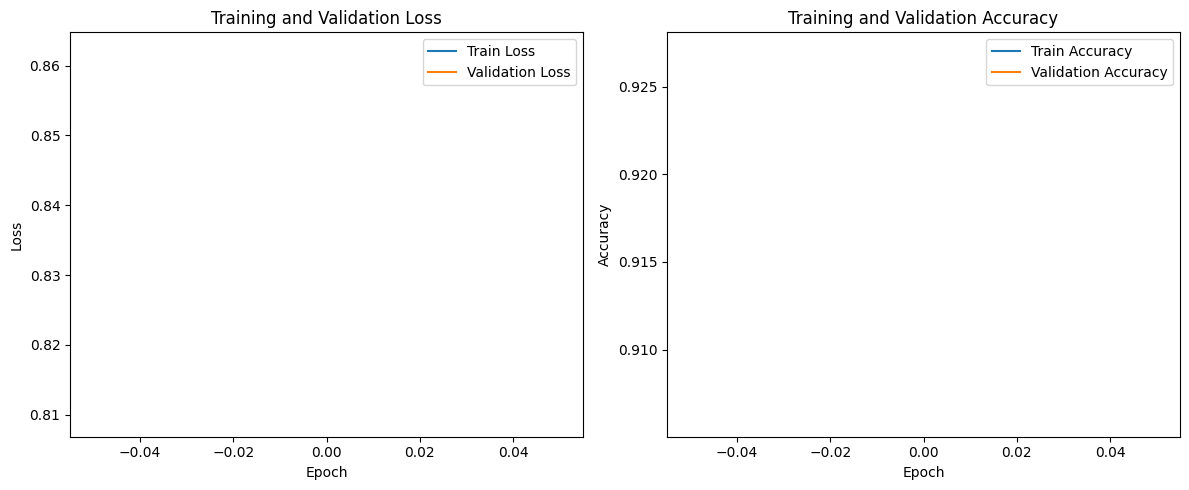

Loading best model for testing...


<ipython-input-5-75eafd52aff6>:471: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
Evaluating: 100%|██████████| 172/172 [01


Test Loss: 1.2561, Test Accuracy: 0.8698


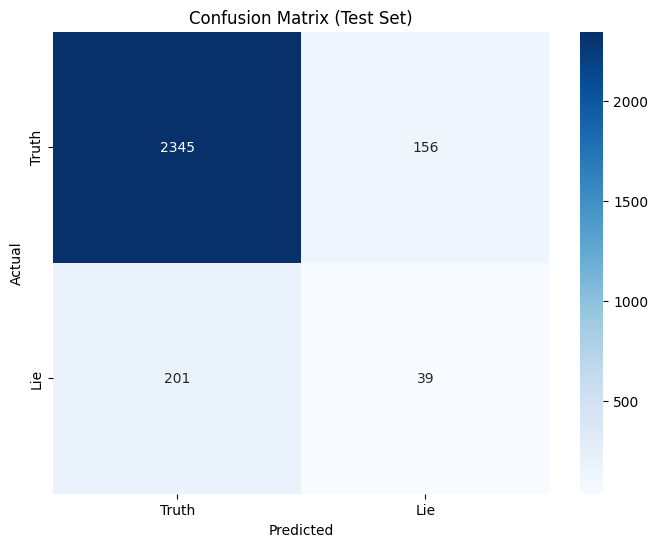


Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      2501
         1.0       0.20      0.16      0.18       240

    accuracy                           0.87      2741
   macro avg       0.56      0.55      0.55      2741
weighted avg       0.86      0.87      0.86      2741


Inference Example:
Message: I will definitely support your move into the North Sea.
Deception Probability: 0.3344
Prediction: Truthful


In [5]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from torch import nn
import torch.nn.functional as F

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Paths
TRAIN_PATH = '/kaggle/input/diplomacy-dataset/train.jsonl'
VALIDATION_PATH = '/kaggle/input/diplomacy-dataset/validation.jsonl'
TEST_PATH = '/kaggle/input/diplomacy-dataset/test.jsonl'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
MAX_LEN = 128
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 1
CONTEXT_SIZE = 5  # Number of previous messages to consider as context
HIDDEN_SIZE = 256
NUM_LAYERS = 2
DROPOUT = 0.3
ATTENTION_HEADS = 4
POSITIVE_WEIGHT = 10.0  # Weight for the positive (lie) class to handle imbalance

# Load and preprocess data
class DiplomacyDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_len=128, context_size=5):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.context_size = context_size
        
        # Load data
        self.games = []
        with open(data_path, 'r') as f:
            for line in f:
                self.games.append(json.loads(line))
        
        # Create samples with context
        self.samples = []
        for game in self.games:
            messages = game['messages']
            sender_labels = game['sender_labels']
            relative_indices = game['relative_message_index']
            game_scores_delta = game.get('game_score_delta', [0] * len(messages))
            speakers = game['speakers']
            
            # Convert game_score_delta to float if it's a string
            game_scores_delta = [float(d) if isinstance(d, str) else (0.0 if d is None else float(d)) 
                               for d in game_scores_delta]
            
            for i in range(len(messages)):
                # Skip messages with no annotation
                if sender_labels[i] == "NOANNOTATION":
                    continue
                    
                # Get label (true = truthful, false = lying)
                is_lying = not (sender_labels[i] if isinstance(sender_labels[i], bool) else sender_labels[i] == "true")
                
                # Get context (previous messages)
                context = []
                for j in range(max(0, i - context_size), i):
                    context.append(messages[j])
                
                # Create sample
                self.samples.append({
                    'message': messages[i],
                    'context': context,
                    'is_lying': is_lying,
                    'game_score_delta': game_scores_delta[i] if i < len(game_scores_delta) else 0.0,
                    'speaker': speakers[i] if i < len(speakers) else "unknown"
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        message = sample['message']
        context = sample['context']
        
        # Tokenize the current message
        encoding = self.tokenizer.encode_plus(
            message,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        # Tokenize context messages
        context_encodings = []
        for ctx_msg in context:
            ctx_encoding = self.tokenizer.encode_plus(
                ctx_msg,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            context_encodings.append({
                'input_ids': ctx_encoding['input_ids'].squeeze(0),
                'attention_mask': ctx_encoding['attention_mask'].squeeze(0)
            })
        
        # Pad context if needed
        while len(context_encodings) < self.context_size:
            pad_encoding = {
                'input_ids': torch.zeros(self.max_len, dtype=torch.long),
                'attention_mask': torch.zeros(self.max_len, dtype=torch.long)
            }
            context_encodings.append(pad_encoding)
        
        # Create feature tensor
        features = torch.tensor([float(sample['game_score_delta'])], dtype=torch.float)
        
        # Get label
        label = 1 if sample['is_lying'] else 0
        
        return {
            'message_input_ids': encoding['input_ids'].squeeze(0),
            'message_attention_mask': encoding['attention_mask'].squeeze(0),
            'context_input_ids': torch.stack([ctx['input_ids'] for ctx in context_encodings]),
            'context_attention_mask': torch.stack([ctx['attention_mask'] for ctx in context_encodings]),
            'features': features,
            'label': torch.tensor(label, dtype=torch.long)
        }

# Model Architecture
class HierarchicalLSTMAttention(nn.Module):
    def __init__(self, hidden_size, num_layers, dropout, num_heads, context_size):
        super(HierarchicalLSTMAttention, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        
        # Freeze some transformer layers to reduce overfitting
        for param in self.roberta.embeddings.parameters():
            param.requires_grad = False
        for i in range(8):  # Freeze first 8 layers (out of 12)
            for param in self.roberta.encoder.layer[i].parameters():
                param.requires_grad = False
                
        self.embedding_size = self.roberta.config.hidden_size  # 768 for roberta-base
        self.hidden_size = hidden_size
        self.context_size = context_size
        
        # BiLSTM for context processing
        self.lstm = nn.LSTM(
            input_size=self.embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Self-attention for context
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,  # BiLSTM output size
            num_heads=num_heads,
            dropout=dropout
        )
        
        # Feature integration
        self.feature_projection = nn.Linear(1, 32)  # 1 feature to 32 dims
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_size + hidden_size * 2 + 32, hidden_size),  # Fixed dimension
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, message_input_ids, message_attention_mask, 
                context_input_ids, context_attention_mask, features):
        batch_size = message_input_ids.size(0)
        
        # Process current message
        message_outputs = self.roberta(
            input_ids=message_input_ids,
            attention_mask=message_attention_mask
        )
        message_embedding = message_outputs.last_hidden_state[:, 0, :]  # CLS token
        
        # Process context messages
        context_embeddings = []
        for i in range(batch_size):
            context_batch_outputs = self.roberta(
                input_ids=context_input_ids[i],
                attention_mask=context_attention_mask[i]
            )
            # Get CLS token for each context message
            context_batch_embeddings = context_batch_outputs.last_hidden_state[:, 0, :]
            context_embeddings.append(context_batch_embeddings)
        
        context_embeddings = torch.stack(context_embeddings)  # [batch_size, context_size, embedding_dim]
        
        # Process sequence with BiLSTM
        lstm_out, _ = self.lstm(context_embeddings)  # [batch_size, context_size, hidden_size*2]
        
        # Apply self-attention
        # Reshape for attention: [seq_len, batch_size, hidden_dim]
        lstm_out = lstm_out.transpose(0, 1)
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Return to original shape and mean pooling
        attn_output = attn_output.transpose(0, 1)
        context_vector = torch.mean(attn_output, dim=1)  # [batch_size, hidden_size*2]
        
        # Process features
        feature_vector = self.feature_projection(features)  # [batch_size, 32]
        
        # Concatenate message, context and features
        combined = torch.cat([message_embedding, context_vector, feature_vector], dim=1)
        
        # Classification
        logits = self.classifier(combined).squeeze(-1)
        
        return logits

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Prepare datasets
print("Loading datasets...")
train_dataset = DiplomacyDataset(TRAIN_PATH, tokenizer, MAX_LEN, CONTEXT_SIZE)
val_dataset = DiplomacyDataset(VALIDATION_PATH, tokenizer, MAX_LEN, CONTEXT_SIZE)
test_dataset = DiplomacyDataset(TEST_PATH, tokenizer, MAX_LEN, CONTEXT_SIZE)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Check class distribution
def check_class_distribution(dataset):
    lie_count = 0
    truth_count = 0
    for i in range(len(dataset)):
        if dataset[i]['label'].item() == 1:
            lie_count += 1
        else:
            truth_count += 1
    return lie_count, truth_count

train_lie, train_truth = check_class_distribution(train_dataset)
print(f"Train dataset - Lies: {train_lie}, Truths: {train_truth}, Ratio: {train_lie/(train_lie+train_truth):.2f}")

# Implement weighted random sampling for handling class imbalance
def create_weighted_sampler(dataset, oversample_ratio=0.25):
    # Get all labels
    labels = []
    for i in range(len(dataset)):
        labels.append(dataset[i]['label'].item())
    
    # Count class instances
    class_counts = torch.bincount(torch.tensor(labels))
    print(f"Original class distribution - Truths: {class_counts[0]}, Lies: {class_counts[1]}")
    
    # Calculate weights (inverse of class frequency)
    # Higher weight = more likely to be sampled
    class_weights = 1.0 / class_counts.float()
    
    # Adjust weights for desired ratio
    # For oversample_ratio=0.25, we want lies (class 1) to be 25% of samples
    if oversample_ratio > 0:
        # Calculate how many samples of each class we'd have with current weights
        current_ratio = class_weights[1] * class_counts[1] / (class_weights[0] * class_counts[0] + class_weights[1] * class_counts[1])
        
        # Adjust weights to get desired ratio
        adjustment = oversample_ratio / current_ratio
        class_weights[1] *= adjustment
        
        # Normalize weights so they sum to 1
        class_weights = class_weights / class_weights.sum()
        
        # Scale up weights to maintain similar number of total samples
        total_samples = class_counts.sum().item()
        class_weights *= total_samples
    
    # Assign weight to each sample based on its class
    sample_weights = [class_weights[labels[i]] for i in range(len(labels))]
    
    # Create and return the sampler
    return torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True  # Sample with replacement to achieve desired ratio
    )

# Create data loaders
# Create weighted sampler for training data
train_sampler = create_weighted_sampler(train_dataset, oversample_ratio=0.25)  # Aim for 25% lies

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=train_sampler  # Use the weighted sampler instead of shuffle=True
)

# Keep validation and test loaders as they were (no oversampling)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Calculate class weights for imbalanced dataset
pos_weight = torch.tensor([POSITIVE_WEIGHT]).to(device)

# Initialize model
model = HierarchicalLSTMAttention(
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    num_heads=ATTENTION_HEADS,
    context_size=CONTEXT_SIZE
).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

# Training function
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        # Move batch to device
        message_input_ids = batch['message_input_ids'].to(device)
        message_attention_mask = batch['message_attention_mask'].to(device)
        context_input_ids = batch['context_input_ids'].to(device)
        context_attention_mask = batch['context_attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].float().to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(
            message_input_ids=message_input_ids,
            message_attention_mask=message_attention_mask,
            context_input_ids=context_input_ids,
            context_attention_mask=context_attention_mask,
            features=features
        )
        
        # Calculate loss
        loss = criterion(logits, labels)
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Predictions
        preds = torch.sigmoid(logits) >= 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'avg_loss': total_loss / (progress_bar.n + 1)
        })
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(data_loader)
    
    return avg_loss, accuracy, all_preds, all_labels

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating")
        
        for batch in progress_bar:
            # Move batch to device
            message_input_ids = batch['message_input_ids'].to(device)
            message_attention_mask = batch['message_attention_mask'].to(device)
            context_input_ids = batch['context_input_ids'].to(device)
            context_attention_mask = batch['context_attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].float().to(device)
            
            # Forward pass
            logits = model(
                message_input_ids=message_input_ids,
                message_attention_mask=message_attention_mask,
                context_input_ids=context_input_ids,
                context_attention_mask=context_attention_mask,
                features=features
            )
            
            # Calculate loss
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Predictions
            preds = torch.sigmoid(logits) >= 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'avg_loss': total_loss / (progress_bar.n + 1)
            })
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(data_loader)
    
    return avg_loss, accuracy, all_preds, all_labels

# Training loop
def train():
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        # Train
        train_loss, train_acc, train_preds, train_labels = train_epoch(
            model, train_loader, optimizer, criterion, device
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validate
        val_loss, val_acc, val_preds, val_labels = evaluate(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Calculate confusion matrix for validation
        val_cm = confusion_matrix(val_labels, val_preds)
        print("Validation Confusion Matrix:")
        print(val_cm)
        
        # Print classification report
        print("\nValidation Classification Report:")
        print(classification_report(val_labels, val_preds))
        
        # Update learning rate based on validation accuracy
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    
    return train_losses, val_losses, train_accs, val_accs

# Train the model
print("Starting training...")
train_losses, val_losses, train_accs, val_accs = train()

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Load best model for final evaluation
print("Loading best model for testing...")
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Confusion matrix for test set
test_cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    test_cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Truth', 'Lie'],
    yticklabels=['Truth', 'Lie']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.savefig('confusion_matrix.png')
plt.show()

print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds))

# Function for inference on new messages
def predict_deception(model, tokenizer, message, context=None, game_score_delta=0):
    model.eval()
    
    # Prepare message
    message_encoding = tokenizer.encode_plus(
        message,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Prepare context
    if context is None:
        context = []
    
    context_encodings = []
    for ctx_msg in context[:CONTEXT_SIZE]:
        ctx_encoding = tokenizer.encode_plus(
            ctx_msg,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        context_encodings.append({
            'input_ids': ctx_encoding['input_ids'].squeeze(0),
            'attention_mask': ctx_encoding['attention_mask'].squeeze(0)
        })
    
    # Pad context if needed
    while len(context_encodings) < CONTEXT_SIZE:
        pad_encoding = {
            'input_ids': torch.zeros(MAX_LEN, dtype=torch.long),
            'attention_mask': torch.zeros(MAX_LEN, dtype=torch.long)
        }
        context_encodings.append(pad_encoding)
    
    # Create feature tensor
    features = torch.tensor([[float(game_score_delta)]], dtype=torch.float)
    
    # Move to device
    message_input_ids = message_encoding['input_ids'].to(device)
    message_attention_mask = message_encoding['attention_mask'].to(device)
    context_input_ids = torch.stack([ctx['input_ids'] for ctx in context_encodings]).unsqueeze(0).to(device)
    context_attention_mask = torch.stack([ctx['attention_mask'] for ctx in context_encodings]).unsqueeze(0).to(device)
    features = features.to(device)
    
    # Predict
    with torch.no_grad():
        logits = model(
            message_input_ids=message_input_ids,
            message_attention_mask=message_attention_mask,
            context_input_ids=context_input_ids,
            context_attention_mask=context_attention_mask,
            features=features
        )
        
        prob = torch.sigmoid(logits).item()
        prediction = prob >= 0.5
    
    return {
        'message': message,
        'probability': prob,
        'is_lying': prediction
    }

# Example usage of the inference function
print("\nInference Example:")
example_message = "I will definitely support your move into the North Sea."
example_context = [
    "Can you help me attack Germany?",
    "I'm considering a move into the North Sea.",
    "What are your plans for the next turn?"
]
example_game_score_delta = -0.2  # Negative score delta (speaker has less power)

result = predict_deception(
    model=model,
    tokenizer=tokenizer,
    message=example_message,
    context=example_context,
    game_score_delta=example_game_score_delta
)

print(f"Message: {result['message']}")
print(f"Deception Probability: {result['probability']:.4f}")
print(f"Prediction: {'Deceptive' if result['is_lying'] else 'Truthful'}")